In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 94% 19.0M/20.1M [00:00<00:00, 101MB/s] 
100% 20.1M/20.1M [00:00<00:00, 94.1MB/s]


In [3]:
!unzip udea*.zip > /dev/null

In [4]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


In [153]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)

shape of loaded dataframe (692500, 12)


In [154]:
from rlxutils import subplots
import matplotlib.pyplot as plt

In [167]:
z.head(100)

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL,ESTU_REGIONES
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto,Centro
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo,Región Caribe
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo,Centro
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto,Región Andina
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo,Región Andina
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,883625,20195,"LICENCIATURA EN EDUCACIÓN FÍSICA, RECREACIÓN Y...",BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Entre 11 y 20 horas,Estrato 1,Si,Primaria incompleta,Primaria completa,Si,medio-bajo,Centro
96,122346,20203,LICENCIATURA EN INGLÉS,SUCRE,Entre 1 millón y menos de 2.5 millones,Más de 30 horas,Estrato 3,Si,Primaria incompleta,Secundaria (Bachillerato) completa,Si,alto,Región Caribe
97,360114,20212,DERECHO,VALLE,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 4,Si,Técnica o tecnológica incompleta,Educación profesional completa,Si,bajo,Región Andina
98,539712,20195,LICENCIATURA EN PEDAGOGIA INFANTIL,VALLE,Entre 500 mil y menos de 1 millón,Más de 30 horas,Estrato 4,Si,Técnica o tecnológica incompleta,Educación profesional incompleta,Si,alto,Región Andina


# Preprocesado de datos
En base a la exploracion de los datos, escogi trabajar con las siguientes columnas:

-ESTU_VALORMATRICULAUNIVERSIDAD

-ESTU_PRGM_DEPARTAMENTO

-Estrato

RENDIMIENTO_GLOBAL

Limpieza de datos nulos

In [161]:
sum(z.ESTU_PRGM_DEPARTAMENTO.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()), sum(z.FAMI_ESTRATOVIVIENDA.isna())

(0, 0, 0)

In [162]:
z.ESTU_PRGM_DEPARTAMENTO.values[z.ESTU_PRGM_DEPARTAMENTO.isna()] = 'no info'
z.ESTU_VALORMATRICULAUNIVERSIDAD.values[z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
z.FAMI_ESTRATOVIVIENDA.values[z.FAMI_ESTRATOVIVIENDA.isna()] = 'no info'
sum(z.ESTU_PRGM_DEPARTAMENTO.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()), sum(z.FAMI_ESTRATOVIVIENDA.isna())

(0, 0, 0)

Limpieza de ESTU_PRGM_DEPARTAMENTO

In [172]:
region_map = {
    'AMAZONAS': 'Amazonía',
    'ANTIOQUIA': 'Región Andina',
    'ARAUCA': 'Región Orinoquía',
    'ATLANTICO': 'Región Caribe',
    'BOGOTÁ': 'Centro',
    'BOLIVAR': 'Región Caribe',
    'BOYACA': 'Región Andina',
    'CALDAS': 'Región Andina',
    'CAQUETA': 'Amazonía',
    'CASANARE': 'Región Orinoquía',
    'CAUCA': 'Región Andina',
    'CESAR': 'Región Caribe',
    'CHOCO': 'Pacífico',
    'CORDOBA': 'Región Caribe',
    'CUNDINAMARCA': 'Centro',
    'GUAVIARE': 'Amazonía',
    'HUILA': 'Región Andina',
    'LA GUAJIRA': 'Región Caribe',
    'MAGDALENA': 'Región Caribe',
    'META': 'Región Orinoquía',
    'NARIÑO': 'Región Andina',
    'NORTE SANTANDER': 'Región Andina',
    'PUTUMAYO': 'Amazonía',
    'QUINDIO': 'Región Andina',
    'RISARALDA': 'Región Andina',
    'SAN ANDRES': 'Insular',
    'SANTANDER': 'Región Andina',
    'SUCRE': 'Región Caribe',
    'TOLIMA': 'Región Andina',
    'VALLE': 'Región Andina',
    'VAUPES': 'Amazonía',
}

In [173]:
z['ESTU_REGIONES'] = z['ESTU_PRGM_DEPARTAMENTO'].map(region_map)


Limpieza de ESTU_VALORMATRICULAUNIVERSIDAD

In [174]:
estudiantes_program = z.groupby('ESTU_VALORMATRICULAUNIVERSIDAD').size()
estudiantes_program

,0
ESTU_VALORMATRICULAUNIVERSIDAD,
Entre 1 millón y menos de 2.5 millones,204048
Entre 2.5 millones y menos de 4 millones,127430
Entre 4 millones y menos de 5.5 millones,69736
Entre 5.5 millones y menos de 7 millones,38490
Entre 500 mil y menos de 1 millón,78704
Menos de 500 mil,80263
Más de 7 millones,68014
No pagó matrícula,19528
no info,6287


In [200]:
import re
import pandas as pd
import numpy as np


def extraer_valores_matricula(rango):
    if isinstance(rango, str):
        rango = rango.lower()

        rango = rango.replace("millones", "").replace("entre", "").replace("menos de", "").replace("más de", "")

        if "no info" in rango:
            return -1
        numeros = re.findall(r'\d+\.?\d*', rango)

        if len(numeros) == 2:

            valor_min = float(numeros[0])
            valor_max = float(numeros[1])
            valor_promedio = (valor_min + valor_max) / 2
            return valor_promedio
        elif len(numeros) == 1:

            return float(numeros[0])
        elif "no pagó matrícula" in rango:

            return 0
    return np.nan


z['ESTU_VALORMATRICULAUNIVERSIDAD'] = z['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna('').astype(str)


z['VALOR_MATRICULA'] = z['ESTU_VALORMATRICULAUNIVERSIDAD'].apply(extraer_valores_matricula)


print(z[['ESTU_VALORMATRICULAUNIVERSIDAD', 'VALOR_MATRICULA']].head())

             ESTU_VALORMATRICULAUNIVERSIDAD  VALOR_MATRICULA
0  Entre 5.5 millones y menos de 7 millones             6.25
1  Entre 2.5 millones y menos de 4 millones             3.25
2  Entre 2.5 millones y menos de 4 millones             3.25
3  Entre 4 millones y menos de 5.5 millones             4.75
4  Entre 2.5 millones y menos de 4 millones             3.25


In [201]:
estudiantes_program = z.groupby('VALOR_MATRICULA').size()
estudiantes_program

,0
VALOR_MATRICULA,
-1.00,6287
0.00,19528
1.75,204048
3.25,127430
4.75,69736
6.25,38490
7.00,68014
250.50,78704
500.00,80263


Limpieza de ESTRATOVIVIENDA

In [202]:
z.FAMI_ESTRATOVIVIENDA = ['no info' if i in ['Sin Estrato'] else i for i in z.FAMI_ESTRATOVIVIENDA.values]

In [203]:
import pandas as pd
import numpy as np

# Diccionario para convertir los estratos en números
estrato_dict = {
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6,
    'no info': -1
}

# Aplicar la conversión en la columna 'FAMI_ESTRATOVIVIENDA'
z['ESTRATO_NUMERO'] = z['FAMI_ESTRATOVIVIENDA'].map(estrato_dict)

# Verifica el resultado
print(z[['FAMI_ESTRATOVIVIENDA', 'ESTRATO_NUMERO']].head())

  FAMI_ESTRATOVIVIENDA  ESTRATO_NUMERO
0            Estrato 3               3
1            Estrato 3               3
2            Estrato 3               3
3            Estrato 4               4
4            Estrato 3               3


In [204]:
estudiantes_program = z.groupby('ESTRATO_NUMERO').size()
estudiantes_program

,0
ESTRATO_NUMERO,
-1,35426
1,111991
2,232671
3,210685
4,65514
5,23608
6,12605


DATOS

In [205]:
datos = z[['ESTU_REGIONES', 'VALOR_MATRICULA', 'ESTRATO_NUMERO','RENDIMIENTO_GLOBAL']]
datos.head()

,ESTU_REGIONES,VALOR_MATRICULA,ESTRATO_NUMERO,RENDIMIENTO_GLOBAL
0,Centro,6.25,3,medio-alto
1,Región Caribe,3.25,3,bajo
2,Centro,3.25,3,bajo
3,Región Andina,4.75,4,alto
4,Región Andina,3.25,3,medio-bajo


convertir en onehot ESTU_REGIONES

In [206]:
x = datos.ESTU_REGIONES.values
ESTU_REGIONES_vals = sorted(np.unique(x))
ESTU_REGIONES_onehot_vals = {val: np.eye(len(ESTU_REGIONES_vals))[i] for i,val in enumerate(ESTU_REGIONES_vals)}
ESTU_REGIONES_onehot_vals

{'Amazonía': array([1., 0., 0., 0., 0., 0., 0.]),
 'Centro': array([0., 1., 0., 0., 0., 0., 0.]),
 'Insular': array([0., 0., 1., 0., 0., 0., 0.]),
 'Pacífico': array([0., 0., 0., 1., 0., 0., 0.]),
 'Región Andina': array([0., 0., 0., 0., 1., 0., 0.]),
 'Región Caribe': array([0., 0., 0., 0., 0., 1., 0.]),
 'Región Orinoquía': array([0., 0., 0., 0., 0., 0., 1.])}

In [207]:
ESTU_REGIONES_onehot_enc = np.r_[[ESTU_REGIONES_onehot_vals[i] for i in datos.ESTU_REGIONES]]
ESTU_REGIONES_onehot_enc

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [208]:
ESTU_REGIONES_df = pd.DataFrame(ESTU_REGIONES_onehot_enc, columns=[f"REGION__{v}" for v in ESTU_REGIONES_onehot_vals])
ESTU_REGIONES_df


,REGION__Amazonía,REGION__Centro,REGION__Insular,REGION__Pacífico,REGION__Región Andina,REGION__Región Caribe,REGION__Región Orinoquía
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
692495,0.0,0.0,0.0,0.0,0.0,1.0,0.0
692496,0.0,0.0,0.0,0.0,1.0,0.0,0.0
692497,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692498,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [209]:
datos = pd.concat([ESTU_REGIONES_df, datos], axis=1).drop('ESTU_REGIONES', axis=1)
datos.shape

(692500, 10)

In [210]:
datos.head()

,REGION__Amazonía,REGION__Centro,REGION__Insular,REGION__Pacífico,REGION__Región Andina,REGION__Región Caribe,REGION__Región Orinoquía,VALOR_MATRICULA,ESTRATO_NUMERO,RENDIMIENTO_GLOBAL
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.25,3,medio-alto
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.25,3,bajo
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.25,3,bajo
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.75,4,alto
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.25,3,medio-bajo


Limpieza de RENDIMIENTO_GLOBAL

In [211]:
y = 'RENDIMIENTO_GLOBAL'

rg = { 'bajo':0, 'medio-bajo':1, 'medio-alto':2, 'alto': 3}
datos[y] = [rg[i] for i in datos[y]]


In [212]:
datos.head()

,REGION__Amazonía,REGION__Centro,REGION__Insular,REGION__Pacífico,REGION__Región Andina,REGION__Región Caribe,REGION__Región Orinoquía,VALOR_MATRICULA,ESTRATO_NUMERO,RENDIMIENTO_GLOBAL
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.25,3,2
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.25,3,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.25,3,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.75,4,3
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.25,3,1


# Construcción del modelo

In [213]:
datos = datos[sorted(datos.columns)]

X = datos[[c for c in datos.columns if c!=y]].values
Y = datos[y].values
X.shape, Y.shape

((692500, 9), (692500,))

In [214]:
from sklearn.model_selection import train_test_split

In [215]:
Xtr, Xts, ytr, yts = train_test_split(X,Y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 9), (138500, 9), (554000,), (138500,))

In [216]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(Xtr, ytr)


GradientBoostingClassifier()

In [218]:
preds_tr = model.predict(Xtr)
preds_ts = model.predict(Xts)

In [221]:
print (preds_tr[:20])
print (preds_ts[:20])

[0 1 0 1 0 0 0 1 2 1 0 3 2 0 0 3 2 3 3 1]
[3 3 1 1 0 3 3 0 0 0 3 0 0 3 0 0 3 0 0 0]


Accuracy

In [222]:
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(0.3781895306859206, 0.37975451263537907)

Matriz de confusion

In [223]:
from sklearn.metrics import confusion_matrix

In [224]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)


cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

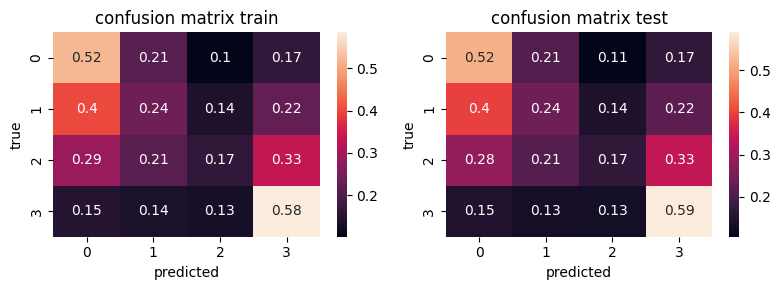

In [225]:
import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## Aplicar modelo al test.csv

In [227]:
w = pd.read_csv("test.csv")
w

,Unnamed: 0,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Primaria incompleta,Si
296782,296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Educación profesional completa,No
296783,296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Educación profesional completa,No
296784,296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Educación profesional completa,No


Limpieza de datos nulos

In [228]:
sum(w.ESTU_PRGM_DEPARTAMENTO.isna()), sum(w.ESTU_VALORMATRICULAUNIVERSIDAD.isna()), sum(w.FAMI_ESTRATOVIVIENDA.isna())

(0, 2723, 13795)

In [229]:
w.ESTU_PRGM_DEPARTAMENTO.values[w.ESTU_PRGM_DEPARTAMENTO.isna()] = 'no info'
w.ESTU_VALORMATRICULAUNIVERSIDAD.values[w.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
w.FAMI_ESTRATOVIVIENDA.values[w.FAMI_ESTRATOVIVIENDA.isna()] = 'no info'
sum(w.ESTU_PRGM_DEPARTAMENTO.isna()), sum(w.ESTU_VALORMATRICULAUNIVERSIDAD.isna()), sum(w.FAMI_ESTRATOVIVIENDA.isna())

(0, 0, 0)

Limpieza de ESTU_PRGM_DEPARTAMENTO

In [230]:
region_map = {
    'AMAZONAS': 'Amazonía',
    'ANTIOQUIA': 'Región Andina',
    'ARAUCA': 'Región Orinoquía',
    'ATLANTICO': 'Región Caribe',
    'BOGOTÁ': 'Centro',
    'BOLIVAR': 'Región Caribe',
    'BOYACA': 'Región Andina',
    'CALDAS': 'Región Andina',
    'CAQUETA': 'Amazonía',
    'CASANARE': 'Región Orinoquía',
    'CAUCA': 'Región Andina',
    'CESAR': 'Región Caribe',
    'CHOCO': 'Pacífico',
    'CORDOBA': 'Región Caribe',
    'CUNDINAMARCA': 'Centro',
    'GUAVIARE': 'Amazonía',
    'HUILA': 'Región Andina',
    'LA GUAJIRA': 'Región Caribe',
    'MAGDALENA': 'Región Caribe',
    'META': 'Región Orinoquía',
    'NARIÑO': 'Región Andina',
    'NORTE SANTANDER': 'Región Andina',
    'PUTUMAYO': 'Amazonía',
    'QUINDIO': 'Región Andina',
    'RISARALDA': 'Región Andina',
    'SAN ANDRES': 'Insular',
    'SANTANDER': 'Región Andina',
    'SUCRE': 'Región Caribe',
    'TOLIMA': 'Región Andina',
    'VALLE': 'Región Andina',
    'VAUPES': 'Amazonía',
}

In [231]:
w['ESTU_REGIONES'] = w['ESTU_PRGM_DEPARTAMENTO'].map(region_map)

Limpieza de ESTU_VALORMATRICULAUNIVERSIDAD

In [232]:
estudiantes_program = w.groupby('ESTU_VALORMATRICULAUNIVERSIDAD').size()
estudiantes_program

,0
ESTU_VALORMATRICULAUNIVERSIDAD,
Entre 1 millón y menos de 2.5 millones,86923
Entre 2.5 millones y menos de 4 millones,55193
Entre 4 millones y menos de 5.5 millones,29855
Entre 5.5 millones y menos de 7 millones,16558
Entre 500 mil y menos de 1 millón,33564
Menos de 500 mil,34589
Más de 7 millones,29061
No pagó matrícula,8320
no info,2723


In [233]:
import re
import pandas as pd
import numpy as np


def extraer_valores_matricula(rango):
    if isinstance(rango, str):
        rango = rango.lower()

        rango = rango.replace("millones", "").replace("entre", "").replace("menos de", "").replace("más de", "")

        if "no info" in rango:
            return -1
        numeros = re.findall(r'\d+\.?\d*', rango)

        if len(numeros) == 2:

            valor_min = float(numeros[0])
            valor_max = float(numeros[1])
            valor_promedio = (valor_min + valor_max) / 2
            return valor_promedio
        elif len(numeros) == 1:

            return float(numeros[0])
        elif "no pagó matrícula" in rango:

            return 0
    return np.nan


w['ESTU_VALORMATRICULAUNIVERSIDAD'] = w['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna('').astype(str)


w['VALOR_MATRICULA'] = w['ESTU_VALORMATRICULAUNIVERSIDAD'].apply(extraer_valores_matricula)


print(w[['ESTU_VALORMATRICULAUNIVERSIDAD', 'VALOR_MATRICULA']].head())

             ESTU_VALORMATRICULAUNIVERSIDAD  VALOR_MATRICULA
0                          Menos de 500 mil           500.00
1  Entre 2.5 millones y menos de 4 millones             3.25
2    Entre 1 millón y menos de 2.5 millones             1.75
3    Entre 1 millón y menos de 2.5 millones             1.75
4  Entre 2.5 millones y menos de 4 millones             3.25


In [234]:
estudiantes_program = w.groupby('VALOR_MATRICULA').size()
estudiantes_program

,0
VALOR_MATRICULA,
-1.00,2723
0.00,8320
1.75,86923
3.25,55193
4.75,29855
6.25,16558
7.00,29061
250.50,33564
500.00,34589


Limpieza de ESTRATOVIVIENDA

In [235]:
w.FAMI_ESTRATOVIVIENDA = ['no info' if i in ['Sin Estrato'] else i for i in w.FAMI_ESTRATOVIVIENDA.values]

In [236]:
import pandas as pd
import numpy as np

# Diccionario para convertir los estratos en números
estrato_dict = {
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6,
    'no info': -1
}

# Aplicar la conversión en la columna 'FAMI_ESTRATOVIVIENDA'
w['ESTRATO_NUMERO'] = w['FAMI_ESTRATOVIVIENDA'].map(estrato_dict)

# Verifica el resultado
print(w[['FAMI_ESTRATOVIVIENDA', 'ESTRATO_NUMERO']].head())

  FAMI_ESTRATOVIVIENDA  ESTRATO_NUMERO
0            Estrato 3               3
1            Estrato 2               2
2            Estrato 3               3
3            Estrato 1               1
4            Estrato 2               2


In [237]:
estudiantes_program = w.groupby('ESTRATO_NUMERO').size()
estudiantes_program

,0
ESTRATO_NUMERO,
-1,15219
1,48092
2,99288
3,90719
4,27823
5,10194
6,5451


Datos

In [239]:
datost_ids = w['ID'].values
datost = w[['ESTU_REGIONES', 'VALOR_MATRICULA', 'ESTRATO_NUMERO']]
print ("shape of loaded dataframe", datost.shape)
datost.head()

shape of loaded dataframe (296786, 3)


,ESTU_REGIONES,VALOR_MATRICULA,ESTRATO_NUMERO
0,Región Caribe,500.00,3
1,Región Andina,3.25,2
2,Centro,1.75,3
3,Región Caribe,1.75,1
4,Región Caribe,3.25,2


convertir en onehot ESTU_REGIONES

In [240]:
f = datost.ESTU_REGIONES.values
ESTU_REGIONES_vals = sorted(np.unique(f))
ESTU_REGIONES_onehot_vals = {val: np.eye(len(ESTU_REGIONES_vals))[i] for i,val in enumerate(ESTU_REGIONES_vals)}
ESTU_REGIONES_onehot_vals

{'Amazonía': array([1., 0., 0., 0., 0., 0., 0.]),
 'Centro': array([0., 1., 0., 0., 0., 0., 0.]),
 'Insular': array([0., 0., 1., 0., 0., 0., 0.]),
 'Pacífico': array([0., 0., 0., 1., 0., 0., 0.]),
 'Región Andina': array([0., 0., 0., 0., 1., 0., 0.]),
 'Región Caribe': array([0., 0., 0., 0., 0., 1., 0.]),
 'Región Orinoquía': array([0., 0., 0., 0., 0., 0., 1.])}

In [241]:
ESTU_REGIONES_onehot_enc = np.r_[[ESTU_REGIONES_onehot_vals[i] for i in datost.ESTU_REGIONES]]
ESTU_REGIONES_onehot_enc

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [242]:
ESTU_REGIONES_df = pd.DataFrame(ESTU_REGIONES_onehot_enc, columns=[f"REGION__{v}" for v in ESTU_REGIONES_onehot_vals])
ESTU_REGIONES_df

,REGION__Amazonía,REGION__Centro,REGION__Insular,REGION__Pacífico,REGION__Región Andina,REGION__Región Caribe,REGION__Región Orinoquía
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
296781,0.0,1.0,0.0,0.0,0.0,0.0,0.0
296782,0.0,0.0,0.0,0.0,0.0,0.0,1.0
296783,0.0,1.0,0.0,0.0,0.0,0.0,0.0
296784,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [243]:
datost = pd.concat([ESTU_REGIONES_df, datost], axis=1).drop('ESTU_REGIONES', axis=1)
datost.shape

(296786, 9)

In [244]:
datost.head()

,REGION__Amazonía,REGION__Centro,REGION__Insular,REGION__Pacífico,REGION__Región Andina,REGION__Región Caribe,REGION__Región Orinoquía,VALOR_MATRICULA,ESTRATO_NUMERO
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,500.00,3
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.25,2
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.75,3
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.75,1
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.25,2


Construccion modelo

In [245]:
X_test_data = datost[sorted(datost.columns)].values
X_test_data.shape

(296786, 9)

In [246]:
preds_test_data = model.predict(X_test_data)

Cargar submission

In [247]:
rmapi = {v:k for k,v in rg.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]

In [248]:
submission = pd.DataFrame([datost_ids, text_preds_test_data], index = ['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-bajo
2,499179,medio-bajo
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,bajo
296782,209415,bajo
296783,239074,medio-alto
296784,963852,alto


In [249]:
submission.to_csv("my_submission.csv", index=False)

In [250]:
!head my_submission.csv

ID,RENDIMIENTO_GLOBAL
550236,alto
98545,medio-bajo
499179,medio-bajo
782980,bajo
785185,bajo
58495,bajo
705444,alto
557548,alto
519909,bajo


In [251]:
submission.shape

(296786, 2)

Enviar a kaggle

In [252]:
!kaggle competitions submit -c udea-ai4eng-20242 -f my_submission.csv -m "Gabriela jimenez submission with linear model"

100% 3.93M/3.93M [00:00<00:00, 5.38MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia